In [397]:
import numpy as np
import torch
import math
from matplotlib import pyplot as plt
from torch import nn

In [398]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)


In [399]:
features[:2], poly_features[:2], labels[:2]


(tensor([[-0.7153],
         [ 0.8986]]),
 tensor([[-0.7153,  0.5117, -0.3660],
         [ 0.8986,  0.8075,  0.7256]]),
 tensor([0.3499, 7.4002]))

In [400]:
def semilogy(x_val,y_val,x_label,y_label,x2_value=None,y2_value=None,legend=None,figsize=(3.5,2.5)):
    plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_val,y_val)
    if x2_value and y2_value:
        plt.semilogy(x2_value,y2_value)
        plt.show()

In [401]:
 loss = torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels,num_epochs=100):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)


final epoch: train loss 8.758100011618808e-05 test loss 0.00011381180956959724


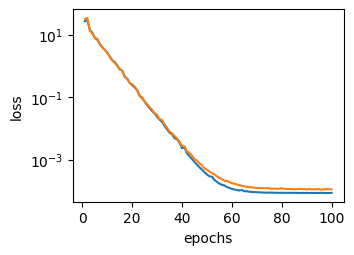

weight: tensor([[ 1.1983, -3.3989,  5.6006]]) 
bias: tensor([4.9976])


In [402]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])


final epoch: train loss 150.12490844726562 test loss 129.81411743164062


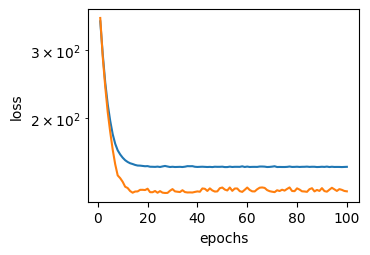

weight: tensor([[16.8310, -3.1457]]) 
bias: tensor([5.8665])


In [403]:
fit_and_plot(poly_features[:n_train, :2], poly_features[n_train:, :2],
            labels[:n_train], labels[n_train:])


final epoch: train loss 149.9130401611328 test loss 130.92405700683594


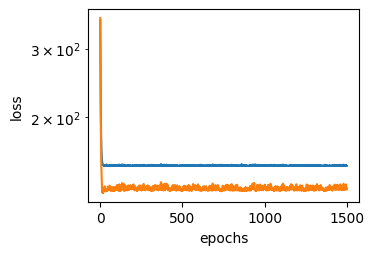

weight: tensor([[16.7626, -3.3687]]) 
bias: tensor([5.8480])


In [404]:
fit_and_plot(poly_features[:n_train, :2], poly_features[n_train:, :2],
            labels[:n_train], labels[n_train:],num_epochs=1500)


权重衰减

In [405]:
n_train,n_test,num_input=20,100,200
true_w,true_b=torch.ones(num_input,1)*0.01,0.05

features=torch.randn([n_train+n_test,num_input])
features.shape

torch.Size([120, 200])

In [406]:
labels=torch.matmul(features,true_w)+true_b
labels+=torch.normal(mean=0,std=0.01,size=labels.size(),dtype=torch.float)
labels.shape

torch.Size([120, 1])

In [407]:
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [408]:
def init_params():
    w = torch.randn((num_input, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]


In [409]:
def penalty(w):
    return (w**2).sum()/2

In [410]:
batch_size = 1
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def train(num_p,num_epochs=100,lr=0.003):
    net=nn.Linear(num_input,1)
    nn.init.normal_(net.weight,mean=0,std=0.01)
    nn.init.normal_(net.bias,mean=0,std=0.01)
    train_ls,test_ls=[],[]
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=num_p) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    loss=nn.MSELoss()
    for i in range(num_epochs):
        for x,y in train_iter:
            l=loss(net(x),y)
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.mean().backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    semilogy(range(num_epochs),train_ls,'epochs','loss',range(num_epochs),test_ls,['train','test'])
    print('L2 norm of w:',  net.weight.data.norm().item())


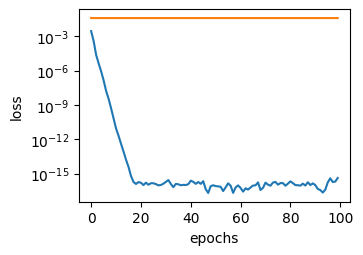

L2 norm of w: 0.1393246054649353


In [411]:
train(num_p=0)

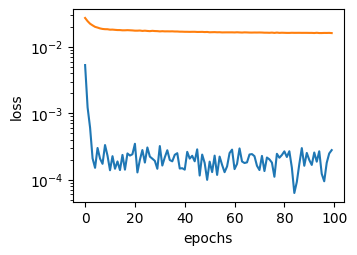

L2 norm of w: 0.044814348220825195


In [412]:
train(num_p=3)

丢弃法

In [413]:
def drop(x,pro):
    x=x.float()
    keep_pro=1-pro
    if keep_pro==0:
        return torch.zeros_like(x)
    mask=(torch.rand(x.shape) < keep_pro).float()
    return mask * x/keep_pro

In [414]:
x = torch.arange(16).view(2, 8)
x

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [415]:
drop(x, 0.1)

tensor([[ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778],
        [ 8.8889, 10.0000, 11.1111, 12.2222, 13.3333, 14.4444, 15.5556, 16.6667]])

In [425]:
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
batch_size=256
threat_num=4
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=threat_num)
test_iter=data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=threat_num)

In [426]:
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 256, 256
w1=torch.tensor(np.random.normal(0,0.01,[num_inputs,num_hidden1]),dtype=torch.float,requires_grad=True)
b1=torch.zeros(num_hidden1,requires_grad=True)
w2=torch.tensor(np.random.normal(0,0.01,[num_hidden1,num_hidden2]),dtype=torch.float,requires_grad=True)
b2=torch.zeros(num_hidden2,requires_grad=True)
w3=torch.tensor(np.random.normal(0,0.01,[num_hidden2,num_outputs]),dtype=torch.float,requires_grad=True)
b3=torch.zeros(num_outputs,requires_grad=True)
params = [w1, b1, w2, b2, w3, b3]
lr=0.001

In [427]:
def net(x,d1=0.2,d2=0.5,is_train=True):
    X=x.view(-1,num_inputs)
    H1 = (torch.matmul(X, w1) + b1).relu()
    if is_train:
        H1=drop(H1,d1)
    H2=(torch.matmul(H1,w2)+b2).relu()
    if is_train:
        H2=drop(H2,d2)
    return torch.matmul(H2,w3)+b3


In [428]:
def train(net1, train_iter1, test_iter1, params,lr, loss1=nn.CrossEntropyLoss(), num_epochs=10):
    l1=[]
    l2=[]
    l3=[]
    optimizer=torch.optim.SGD(params,lr)
    for epoch in range(num_epochs):
        sum_loss,acc_train,n_train1,acc_test,n_test1=0,0,0,0,0
        for x,y in train_iter1:
            k=net1(x)
            l=loss1(k, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            sum_loss+=l
            acc_train+=(k.argmax(dim=1)==y).float().sum().item()
            n_train1+=y.shape[0]
        for x,y in test_iter1:
            if 'is_training' in net.__code__.co_varnames:
                k=net1(x,False )
            else:
                k=net1(x)
                acc_test+=(k.argmax(dim=1)==y).float().sum().item()
                n_test1+=y.shape[0]
        print("epoch: "+str(epoch+1))
        print("acc_train: " + str(acc_train / n_train1))
        print("test_acc: " + str(acc_test / n_test1))
        print("sum_loss: " + str(sum_loss.sum().item() / n_train1))
        l1.append(acc_train / n_train1)
        l2.append(acc_test / n_test1)
        l3.append(sum_loss.sum().item() / n_train1)
    plt.plot(range(num_epochs),l1)
    plt.plot(range(num_epochs),l2)
    plt.legend(["train_acc","test_acc"])
    plt.show()
    plt.plot(range(num_epochs),l3)
    plt.show()


epoch: 1
acc_train: 0.12543333333333334
test_acc: 0.1373
sum_loss: 0.009016788736979166
epoch: 2
acc_train: 0.14548333333333333
test_acc: 0.1456
sum_loss: 0.009015704345703125
epoch: 3
acc_train: 0.16043333333333334
test_acc: 0.1701
sum_loss: 0.009014730834960938
epoch: 4
acc_train: 0.17313333333333333
test_acc: 0.1832
sum_loss: 0.009013600667317708
epoch: 5
acc_train: 0.18983333333333333
test_acc: 0.1972
sum_loss: 0.009012552897135416
epoch: 6
acc_train: 0.20931666666666668
test_acc: 0.2138
sum_loss: 0.009011420694986979
epoch: 7
acc_train: 0.2221
test_acc: 0.2254
sum_loss: 0.009010143025716146
epoch: 8
acc_train: 0.23983333333333334
test_acc: 0.2447
sum_loss: 0.009008951822916667
epoch: 9
acc_train: 0.25611666666666666
test_acc: 0.2472
sum_loss: 0.009007496134440103
epoch: 10
acc_train: 0.26203333333333334
test_acc: 0.2726
sum_loss: 0.009006027221679688


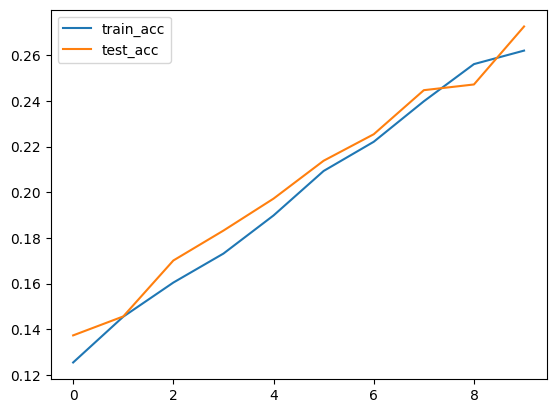

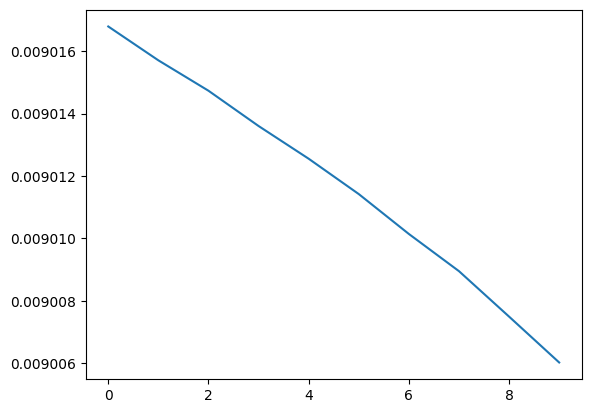

In [420]:
train(net,train_iter,test_iter,params,lr)

In [448]:
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs,num_hidden1),
    nn.Dropout(0.2),
    nn.Linear(num_hidden1,num_hidden2),
    nn.Dropout(0.5),
    nn.Linear(num_hidden2,num_outputs))
for p in net.parameters():
    nn.init.normal(p,mean=0,std=0.01)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.01)
net

C:\Users\sunyu\AppData\Local\Temp\ipykernel_11224\3067081844.py:9: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(p,mean=0,std=0.01)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=10, bias=True)
)

In [449]:
def train(net, train_iter, test_iter,loss,optimizer,num_epochs=10):
    l1,l2,l3=[],[],[]
    for epoch in range(num_epochs):
        sum_loss,acc_train,n_train,acc_test,n_test=0,0,0,0,0
        for x,y in train_iter:
            k=net(x)
            l=loss(k,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            sum_loss+=l.sum()
            acc_train+=(k.argmax(dim=1)==y).float().sum().item()
            n_train+=y.shape[0]
        for x,y in test_iter:
            if isinstance(net,nn.Module):
                net.eval()
                acc_test+=(net(x).argmax(dim=1)==y).float().sum().item()
                net.train()
                n_test+=y.shape[0]
        print("epoch: "+str(epoch+1))
        print("acc_train: " + str(acc_train / n_train))
        print("test_acc: " + str(acc_test / n_test))
        print("sum_loss: " + str(sum_loss.sum().item() / n_train))
        l1.append(acc_train / n_train)
        l2.append(acc_test / n_test)
        l3.append(sum_loss.sum().item() / n_train)
    plt.plot(range(num_epochs),l1)
    plt.plot(range(num_epochs),l2)
    plt.legend(["train_acc","test_acc"])
    plt.show()
    plt.plot(range(num_epochs),l3)
    plt.show()

epoch: 1
acc_train: 0.24736666666666668
test_acc: 0.3807
sum_loss: 0.008986240641276042
epoch: 2
acc_train: 0.28225
test_acc: 0.2684
sum_loss: 0.008801774088541667
epoch: 3
acc_train: 0.39126666666666665
test_acc: 0.4524
sum_loss: 0.007440339152018229
epoch: 4
acc_train: 0.4768833333333333
test_acc: 0.5158
sum_loss: 0.005455982971191407
epoch: 5
acc_train: 0.5246333333333333
test_acc: 0.5505
sum_loss: 0.004639080810546875


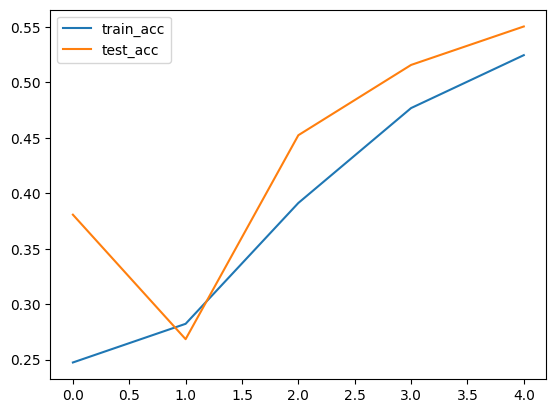

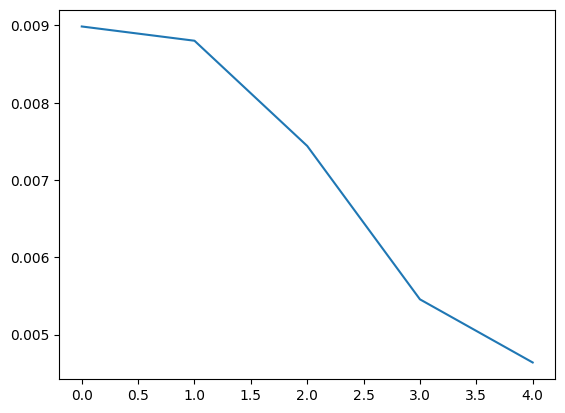

In [450]:
train(net,train_iter,test_iter,loss,optimizer,5)